In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge,RidgeCV, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold,
)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

import yellowbrick.regressor as yr
from yellowbrick.model_selection import ValidationCurve, LearningCurve, RFECV, FeatureImportances
import yellowbrick.features as yb
import yellowbrick.target as yt
import yellowbrick.regressor as yr

from scipy.stats import zscore

# Data pre-processing

In [ ]:
# Add links for training and testing files
training_file = "https://raw.githubusercontent.com/kanmaytacker/N-AAI-SLM/master/Assignment/data/train_selected.csv"
test_file = "https://raw.githubusercontent.com/kanmaytacker/N-AAI-SLM/master/Assignment/data/test_selected_ttf.csv"

In [ ]:
# Read test and training data
training_data = pd.read_csv(training_file)
test_data = pd.read_csv(test_file)

In [ ]:
# Print first 5 rows of training data
training_data.head()

,id,cycle,s1,s2,s3,s4,ttf,label_bnc
0,1,1,1400.60,554.36,47.47,521.66,191,0
1,1,2,1403.14,553.75,47.49,522.28,190,0
2,1,3,1404.20,554.26,47.27,522.42,189,0
3,1,4,1401.87,554.45,47.13,522.86,188,0
4,1,5,1406.22,554.00,47.28,522.19,187,0


In [ ]:
# Print last 5 rows of training data
training_data.tail()

,id,cycle,s1,s2,s3,s4,ttf,label_bnc
20626,100,196,1428.63,551.43,48.07,519.49,4,1
20627,100,197,1433.58,550.86,48.04,519.68,3,1
20628,100,198,1428.18,550.94,48.09,520.01,2,1
20629,100,199,1426.53,550.68,48.39,519.67,1,1
20630,100,200,1432.14,550.79,48.20,519.30,0,1


In [ ]:
# Find the number of rows and columns in the training data
training_data.shape

(20631, 8)

In [ ]:
# Find the number of rows and columns in the test data
test_data.shape

(100, 8)

In [ ]:
# Define column names
columns = ['ID', 'CYCLE', 'S1', 'S2', 'S3', 'S4', 'TTF', 'TTF_LABEL']

In [ ]:
# Rename the columns
training_data.columns = columns
test_data.columns = columns

In [ ]:
# Define the features and target variables
sensors = ['S1', 'S2', 'S3', 'S4']
cycle = 'CYCLE'
target = 'TTF'
features = [cycle] + sensors

In [ ]:
# Generate subsets

X_sensors = training_data[sensors]

X_base = training_data[features]
y_base = training_data[target]

# Exploratory data analysis

## Descriptive statistics

### Missing values

In [ ]:
# Identify missing values and data types of the training data
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         20631 non-null  int64  
 1   CYCLE      20631 non-null  int64  
 2   S1         20631 non-null  float64
 3   S2         20631 non-null  float64
 4   S3         20631 non-null  float64
 5   S4         20631 non-null  float64
 6   TTF        20631 non-null  int64  
 7   TTF_LABEL  20631 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 1.3 MB


In [ ]:
# Identify missing values and data types of the test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         100 non-null    int64  
 1   CYCLE      100 non-null    int64  
 2   S1         100 non-null    float64
 3   S2         100 non-null    float64
 4   S3         100 non-null    float64
 5   S4         100 non-null    float64
 6   TTF        100 non-null    int64  
 7   TTF_LABEL  100 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 6.4 KB


No missing values in the dataset.

### Central tendency and dispersion

In [ ]:
# Descriptive statistics of the training data
training_data.describe()

,ID,CYCLE,S1,S2,S3,S4,TTF,TTF_LABEL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,1408.933782,553.367711,47.541168,521.413470,107.807862,0.150259
std,29.227633,68.880990,9.000605,0.885092,0.267087,0.737553,68.880990,0.357334
min,1.000000,1.000000,1382.250000,549.850000,46.850000,518.690000,0.000000,0.000000
25%,26.000000,52.000000,1402.360000,552.810000,47.350000,520.960000,51.000000,0.000000
50%,52.000000,104.000000,1408.040000,553.440000,47.510000,521.480000,103.000000,0.000000
75%,77.000000,156.000000,1414.555000,554.010000,47.700000,521.950000,155.000000,0.000000
max,100.000000,362.000000,1441.490000,556.060000,48.530000,523.380000,361.000000,1.000000


In [ ]:
# Aggregate the training data by engine and identify the last cycle of each engine
max_cycle_data = training_data[["ID", "CYCLE"]].groupby('ID').max()
pd.concat([training_data["ID"].describe(), max_cycle_data.describe()], axis=1)

,ID,CYCLE
count,20631.000000,100.000000
mean,51.506568,206.310000
std,29.227633,46.342749
min,1.000000,128.000000
25%,26.000000,177.000000
50%,52.000000,199.000000
75%,77.000000,229.250000
max,100.000000,362.000000


Text(0, 0.5, 'Frequency')

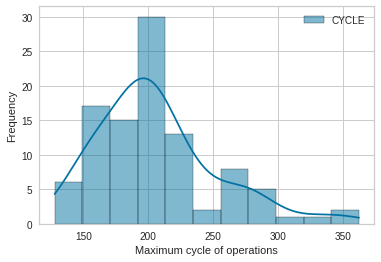

In [ ]:
# Plot histogram of the max cycle of each engine
ax = sns.histplot(max_cycle_data, kde=True)
ax.set_xlabel('Maximum cycle of operations')
ax.set_ylabel('Frequency')

In [ ]:
# Check standard deviation of the sensors
X_sensors.std().sort_values(ascending=False)

S1    9.000605
S2    0.885092
S4    0.737553
S3    0.267087
dtype: float64

Text(0.5, 0, 'Sensor variables')

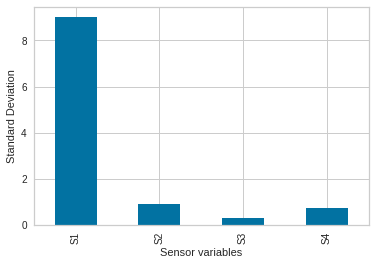

In [ ]:
# Plot standard deviation of the sensors
ax = X_sensors.std().plot(kind='bar')
ax.set_ylabel("Standard Deviation")
ax.set_xlabel("Sensor variables")

Text(0.5, 0, 'Sensor variables')

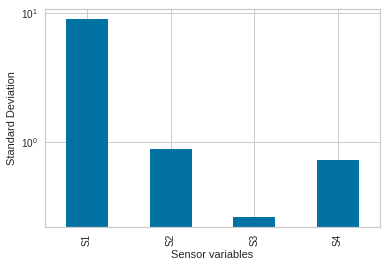

In [ ]:
# Plot log standard deviation of the sensors
ax = X_sensors.std().plot(kind='bar', logy=True)
ax.set_ylabel("Standard Deviation")
ax.set_xlabel("Sensor variables")

### Correlation

In [ ]:
# Check correlation between the dependent and the independent variable
X_base.corrwith(y_base)

CYCLE   -0.736241
S1      -0.678948
S2       0.657223
S3      -0.696228
S4       0.671983
dtype: float64

In [ ]:
# Generate correlation matrix
correlation_matrix = training_data[features + [target]].corr(method='pearson')
correlation_matrix

,CYCLE,S1,S2,S3,S4,TTF
CYCLE,1.000000,0.624577,-0.595914,0.634385,-0.611354,-0.736241
S1,0.624577,1.000000,-0.793130,0.830136,-0.815591,-0.678948
S2,-0.595914,-0.793130,1.000000,-0.822805,0.812713,0.657223
S3,0.634385,0.830136,-0.822805,1.000000,-0.846884,-0.696228
S4,-0.611354,-0.815591,0.812713,-0.846884,1.000000,0.671983
TTF,-0.736241,-0.678948,0.657223,-0.696228,0.671983,1.000000


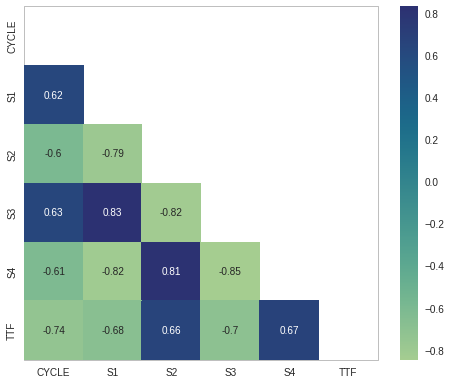

In [ ]:
# Plot correlation matrix

plt.figure(figsize=(8, 6.5))

# Generate mask for upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
ax = sns.heatmap(correlation_matrix, annot=True, mask=mask, square=True, cmap='crest')

# Add borders
ax.patch.set_edgecolor('gray')  
ax.patch.set_linewidth('.5') 

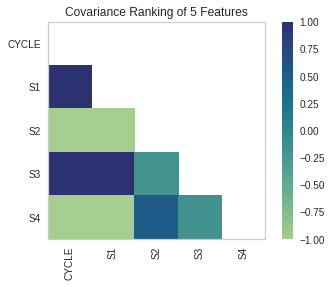

In [ ]:
# Generate covariance matrix
visualizer = yb.Rank2D(algorithm="covariance", colormap="crest")
visualizer.fit_transform(training_data[features])
visualizer.show()

## Visual EDA

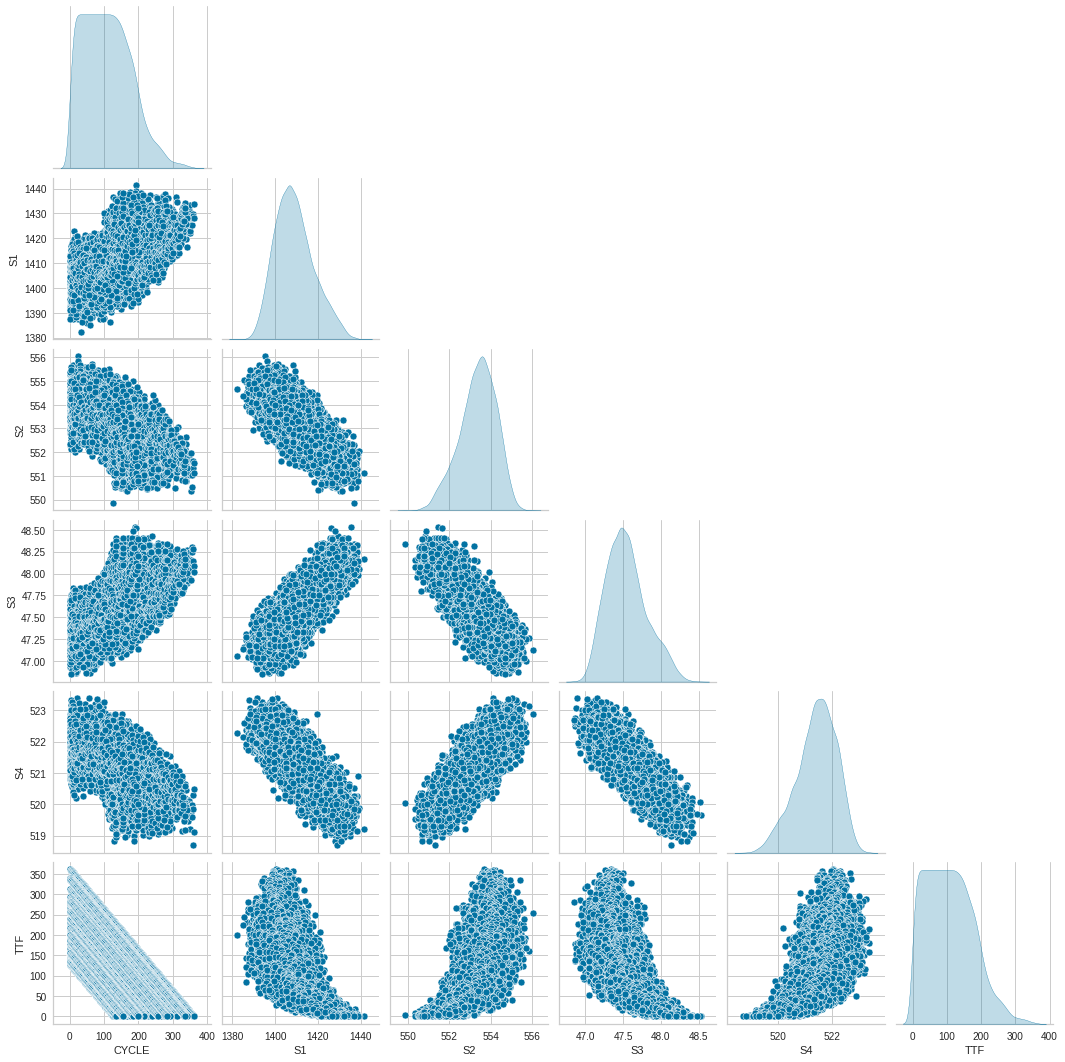

In [ ]:
# Plot a pairplot of the dependent and independent variables
sns.pairplot(
    training_data[features + [target]],
    corner=True,
    diag_kind="kde"
)


### Skewness and kurtosis

In [ ]:
# Check skewness of the features
X_base.skew().sort_values(ascending=False)

CYCLE    0.499904
S3       0.469329
S1       0.443194
S2      -0.394329
S4      -0.442407
dtype: float64

In [ ]:
# Check kutosis of the features
X_base.kurt().sort_values(ascending=False)

S4      -0.144917
S2      -0.157949
S1      -0.163681
S3      -0.172192
CYCLE   -0.218539
dtype: float64

### Time series

In [ ]:
def plot_sensor_sampled(data: pd.DataFrame, sensor_name: str, sample_size: int) -> None:
    """
    Plot a sampled time series of a sensor.

    data (DataFrame): The training data
    sensor_name (str): The name of the sensor to plot
    sample_size (int): The number of engines to sample from
    """
    # Generate a random sample of the engines
    engines = np.random.choice(range(1, 101), sample_size, replace=False)
    plt.figure()

    # Plot the time series of the sensor for each engine
    for engine in engines:
        fig = sns.lineplot(
            x="TTF", y=sensor_name, data=data[data["ID"] == engine], palette="pastel"
        )

    # Add labels and ticks
    fig.set(ylabel=sensor_name)
    fig.set(xlabel="Time-To-Failure")
    fig.set(xticks=np.arange(0, 275, 25))
    fig.set(xlim=(250, 0))


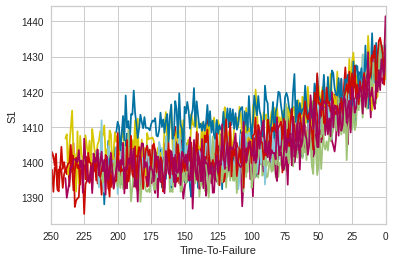

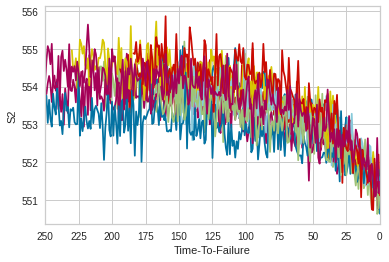

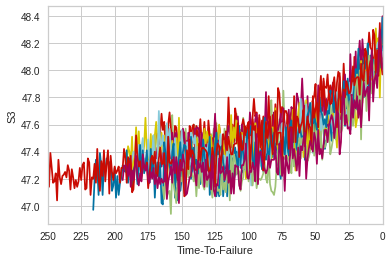

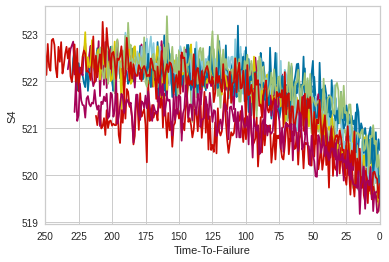

In [ ]:
sample_size = 10
for sensor in sensors:
    plot_sensor_sampled(training_data,sensor, sample_size)

### Classification

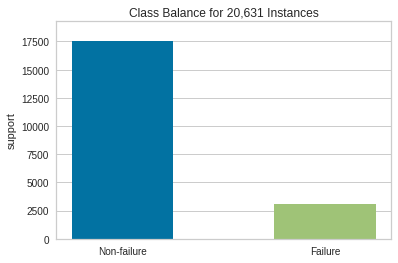

In [ ]:
# Check class imbalance
visualizer= yt.ClassBalance(labels=['Non-failure', 'Failure'])
visualizer.fit(training_data['TTF_LABEL'])
visualizer.show()

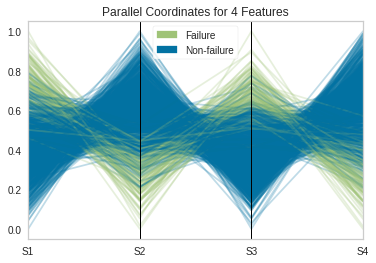

,S1,S2,S3,S4
0,1400.60,554.36,47.47,521.66
1,1403.14,553.75,47.49,522.28
2,1404.20,554.26,47.27,522.42
3,1401.87,554.45,47.13,522.86
4,1406.22,554.00,47.28,522.19
...,...,...,...,...
20626,1428.63,551.43,48.07,519.49
20627,1433.58,550.86,48.04,519.68
20628,1428.18,550.94,48.09,520.01
20629,1426.53,550.68,48.39,519.67


In [ ]:
# Check linear separability
visualizer = yb.ParallelCoordinates(classes=['Non-failure', 'Failure'], sample=0.05, shuffle=True, normalize='minmax')
visualizer.fit_transform_show(X_sensors, training_data['TTF_LABEL'])

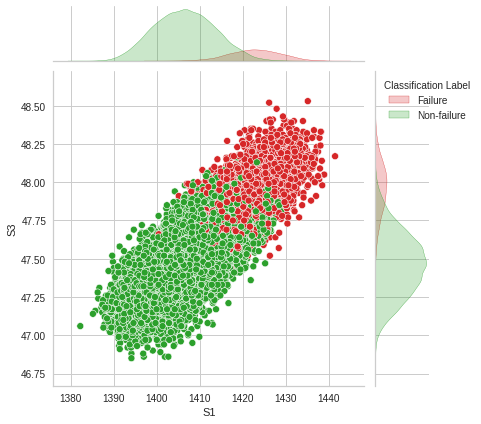

In [ ]:
fig = sns.jointplot(x='S1', y='S3', data=training_data, hue='TTF_LABEL', palette=['tab:green', 'tab:red'], legend=False)
plt.legend(loc=2,title='Classification Label', labels=['Failure', 'Non-failure'])
plt.show(fig)

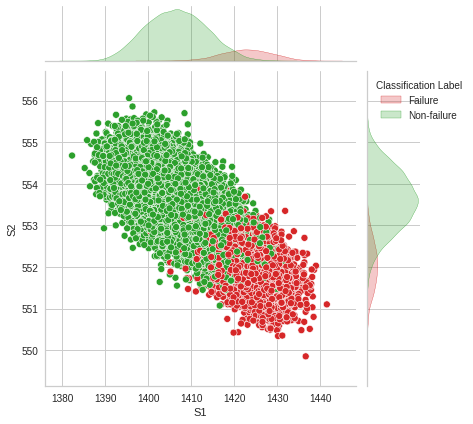

In [ ]:
fig = sns.jointplot(x='S1', y='S2', data=training_data, hue='TTF_LABEL', palette=['tab:green', 'tab:red'], legend=False)
plt.legend(loc=2,title='Classification Label', labels=['Failure', 'Non-failure'])
plt.show(fig)

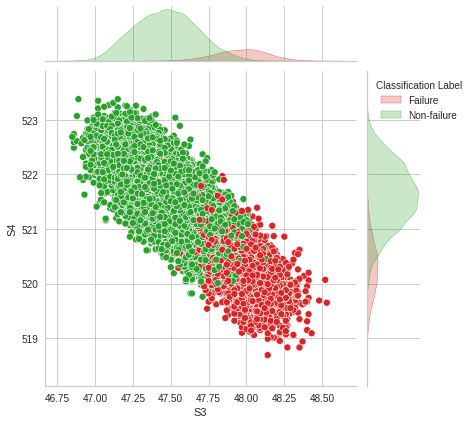

In [ ]:
fig = sns.jointplot(x='S3', y='S4', data=training_data, hue='TTF_LABEL', palette=['tab:green', 'tab:red'], legend=False)
plt.legend(loc=2,title='Classification Label', labels=['Failure', 'Non-failure'])
plt.show(fig)

## Data scaling

In [ ]:
# Use min-max scaling to normalize the data across sensors and not cycles
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_sensors)

MinMaxScaler()

In [ ]:
# Transform the training and test data
sensors_train_scaled = min_max_scaler.transform(X_sensors)
sensors_test_scaled = min_max_scaler.transform(test_data[sensors])

In [ ]:
# Make dataframe of the scaled data
train_scaled_df = pd.DataFrame(sensors_train_scaled, columns=sensors)
test_scaled_df = pd.DataFrame(sensors_test_scaled, columns=sensors)

In [ ]:
# Combine scaled with other columns
train_scaled = pd.concat([training_data[["ID", "CYCLE", "TTF", "TTF_LABEL"]], train_scaled_df], axis=1)
test_scaled = pd.concat([test_data[["ID", "CYCLE", "TTF", "TTF_LABEL"]], test_scaled_df], axis=1)

In [ ]:
X_sensors_scaled = train_scaled[sensors]

X_scaled = train_scaled[features]
y_scaled = train_scaled[target]

In [ ]:
X_test_scaled = test_scaled[features]
y_test_scaled = test_scaled[target]

## Outlier Detection

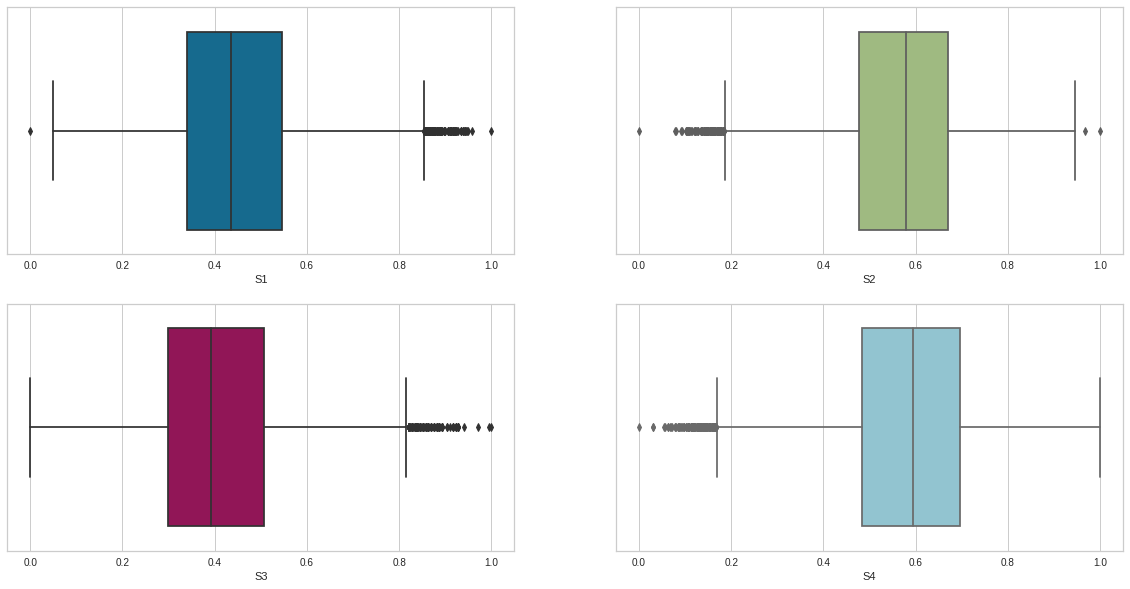

In [ ]:
# Display a box and whisker plot of the sensor data

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
sns.boxplot(x=X_sensors_scaled['S1'], ax=axs[0, 0], color="#0272a2")
sns.boxplot(x=X_sensors_scaled['S2'], ax=axs[0, 1], color="#9fc377")
sns.boxplot(x=X_sensors_scaled['S3'], ax=axs[1, 0], color="#a50258")
sns.boxplot(x=X_sensors_scaled['S4'], ax=axs[1, 1], color="#88cada")

### Numeric Outlier Technique

In [ ]:

multiplier = 1.5
outliers = {}

for sensor in sensors:
    
    # Generate quantiles and IQR
    quantiles = X_sensors_scaled[[sensor]].quantile([0.25, 0.75])
    
    q1 = quantiles.iloc[0, 0]
    q3 = quantiles.iloc[1, 0]
    iqr = q3 - q1
    
    # Generate upper and lower bounds
    lower_bound = q1 - multiplier*iqr
    upper_bound = q3 + multiplier*iqr
    
    # Find outliers
    num_out_outliers_index = X_sensors_scaled[(X_sensors_scaled[sensor] > upper_bound) | (X_sensors_scaled[sensor] < lower_bound)].index
    outliers[sensor] = num_out_outliers_index

In [ ]:
# Combine the outliers across columns
combined = set()
for indexes in outliers.values():
    combined.update(set(indexes))

print(f"Number of Outliers: {len(combined)}", )
print(f"Percentage of Outliers: {len(combined) / training_data.shape[0] * 100}%", )

Number of Outliers: 427
Percentage of Outliers: 2.0697009354854345%


### Z-scores

In [ ]:
# Generate Z-Scores
k = 3
z_scores = pd.DataFrame(zscore(X_sensors_scaled), columns=sensors)

In [ ]:
# Find rows with z-scores greater than k or less than -k
z_score_outliers = {}
for col in sensors:
    num_out_outliers_index = z_scores[(z_scores[col] > k) | (z_scores[col] < -k)].index
    z_score_outliers[col] = num_out_outliers_index

In [ ]:
# Combine the outliers across columns
combined = set()
for indexes in z_score_outliers.values():
    combined.update(set(indexes))

print(f"Number of Outliers: {len(combined)}", )
print(f"Percentage of Outliers: {len(combined) / training_data.shape[0] * 100}%", )

Number of Outliers: 115
Percentage of Outliers: 0.5574136008918618%


### Cooks distance

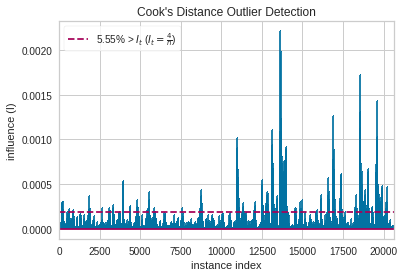

In [ ]:
visualizer = yr.CooksDistance()
visualizer.fit(X_scaled, y_scaled)
visualizer.show()

In [ ]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_regression, y_regression = X_scaled[i_less_influential], y_scaled[i_less_influential]

In [ ]:
# Set an upper threshold for TTF
y_regression = y_regression.clip(upper=125)

In [ ]:
X_regression.shape

(19486, 5)

In [ ]:
X_regression.describe()

,CYCLE,S1,S2,S3,S4
count,19486.000000,19486.000000,19486.000000,19486.000000,19486.000000
mean,108.378015,0.451990,0.565145,0.412739,0.579434
std,65.823866,0.151989,0.142313,0.159140,0.157349
min,1.000000,0.000000,0.000000,0.000000,0.029851
25%,54.000000,0.340859,0.473430,0.297619,0.481876
50%,105.000000,0.437880,0.576490,0.398810,0.592751
75%,156.000000,0.548109,0.668277,0.511905,0.695096
max,327.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
y_regression.describe()

count    19486.000000
mean        85.675100
std         41.687076
min          0.000000
25%         50.000000
50%        100.000000
75%        125.000000
max        125.000000
Name: TTF, dtype: float64

## Feature Selection

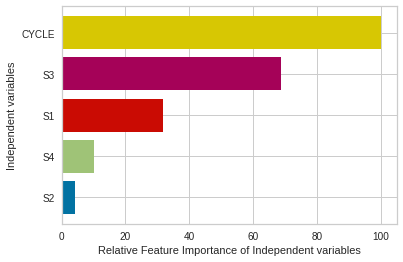

In [ ]:
viz= FeatureImportances(RandomForestRegressor(
    n_estimators=70, max_features=3, max_depth=8
))
viz.fit(X_regression, y_regression)
viz.ax.set_xlabel("Relative Feature Importance of Independent variables")
viz.ax.set_ylabel("Independent variables")

plt.show()

In [ ]:
select_features_regression = ['S1', 'S3', 'CYCLE']
X_regression = X_regression[select_features_regression]

# Regression

## Helper Methods

### Hyperparameter tuning 

In [ ]:
def tune_hyperparameters(regressor, parameters_grid, X_train, y_train, cv=5):

    """Tune the hyperparameters of a regression model using Grid Search

    Args:
        regressor (str): The model name identifier
        parameters_grid (dict): The hyperparameters grid
        X_train (dataframe): The training features
        y_train (series): The training labels
    """
    grid = GridSearchCV(regressor, parameters_grid, cv=cv)
    grid.fit(X_train, y_train)
    print(
        f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}"
    )
    return grid.best_estimator_


### Model fitting and predictions

In [ ]:
def train_model_and_predict(regressor, X_train, y_train, X_test):

    """Train and predict a regression model

    Args:
        regressor (str): The model name identifier
        X_train (dataframe): The training features
        y_train (series): The training labels
        X_test (dataframe): The test features
    """
    regressor.fit(X_train, y_train)
    training_predictions = regressor.predict(X_train)
    test_predictions = regressor.predict(X_test)
    return training_predictions, test_predictions


### Calculate regression metrics on training and test data for a single model
Metrics to be considered:
- RMSE
- R2 score

In [ ]:
def calculate_regression_metrics(
    model_name, training_actual, training_predictions, test_actual, test_predictions
):
    """Calculate regression metrics on training and test data"""
    # Calculate training metrics
    training_r2 = r2_score(training_actual, training_predictions)
    training_rmse = np.sqrt(mean_squared_error(training_actual, training_predictions))

    # Calculate test metrics
    test_r2 = r2_score(test_actual, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))

    return pd.DataFrame(
        {
            f"{model_name} (Training)": {"R2": training_r2, "RMSE": training_rmse},
            f"{model_name} (Test)": {"R2": test_r2, "RMSE": test_rmse},
        }
    )


## Linear Regression

### Base model

In [ ]:
X_test = test_data[features]
y_test = test_data[target]

In [ ]:
# Linear regression on base data
base_linear_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    base_linear_regressor, training_data[features], training_data[target], X_test
)


In [ ]:
# Calculate metrics
base_linear_regression_metrics = calculate_regression_metrics(
    "Linear Regression Base", training_data[target], training_predictions, y_test, test_predictions
)
base_linear_regression_metrics

,Linear Regression Base (Training),Linear Regression Base (Test)
R2,0.644452,0.393569
RMSE,41.071267,32.360897


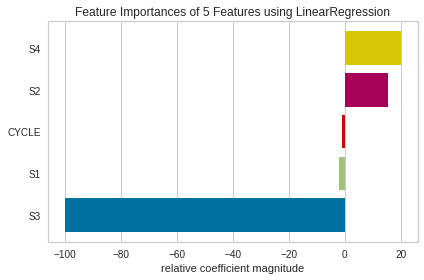

In [ ]:
# Check model coefficients for base model
viz= FeatureImportances(LinearRegression())
viz.fit(training_data[features], training_data[target])
viz.show()

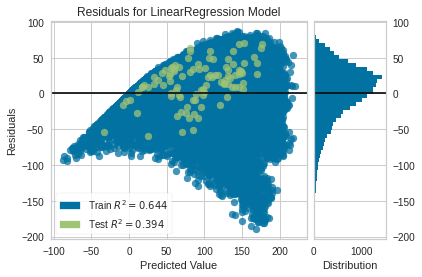

In [ ]:
# Check residuals for base model
visualizer = yr.ResidualsPlot(LinearRegression())
visualizer.fit(training_data[features], training_data[target])
visualizer.score(X_test, y_test)
visualizer.show()

### Final dataset
X_regression has undergone the following steps:
- Normalization
- Outlier removal
- Feature selection - S1, S3, Cycle
- Thresholding of TTF at 125

In [ ]:
X_test_scaled = X_test_scaled[select_features_regression]

In [ ]:
# Linear regression on normalized data
linear_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    linear_regressor, X_regression, y_regression, X_test_scaled
)

In [ ]:
# Calculate metrics
linear_regression_metrics = calculate_regression_metrics(
    "Linear Regression", y_regression, training_predictions, y_test_scaled, test_predictions
)
linear_regression_metrics


,Linear Regression (Training),Linear Regression (Test)
R2,0.744633,0.669816
RMSE,21.065541,23.878555


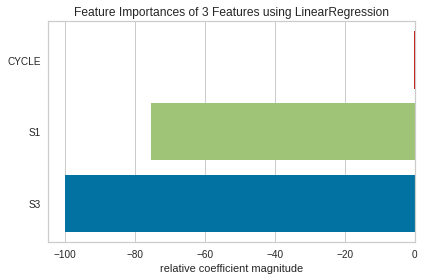

In [ ]:
# Plot model coefficients for linear regression
viz= FeatureImportances(LinearRegression())
viz.fit(X_regression, y_regression)
viz.show()

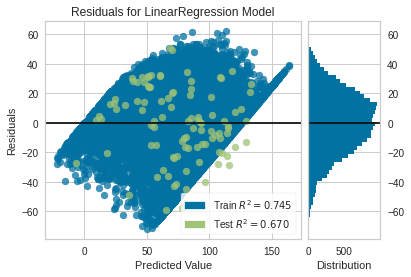

In [ ]:
model = LinearRegression()
visualizer_residuals = yr.ResidualsPlot(model)
visualizer_residuals.fit(X_regression, y_regression)
visualizer_residuals.score(X_test_scaled, y_test_scaled)
visualizer_residuals.show()

### Comparison of base and final models

In [ ]:
# Compare with base linear regression
pd.concat([base_linear_regression_metrics, linear_regression_metrics], axis=1)

,Linear Regression Base (Training),Linear Regression Base (Test),Linear Regression (Training),Linear Regression (Test)
R2,0.644452,0.393569,0.744633,0.669816
RMSE,41.071267,32.360897,21.065541,23.878555


## Polynomial Regression

In [ ]:
# Perform search for best degree of polynomial regression
degree_space = [2, 3, 4, 5]
best_score = 0
best_degree = 0
degree_scores = []

for degree in degree_space:
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_regression)
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X_train_poly, y_regression)
    scores = cross_val_score(
        polynomial_regressor, X_train_poly, y_regression, cv=5
    ) 
    
    score = np.mean(scores)
    degree_scores.append(score)

    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_degree = degree


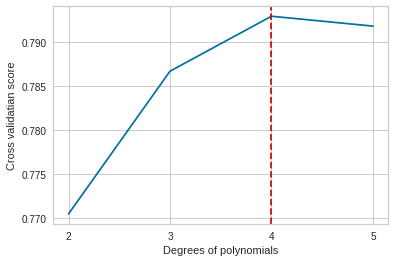

In [ ]:
fig = sns.lineplot(x=degree_space, y=degree_scores)
fig.set(xlabel="Degrees of polynomials", ylabel="Cross validatian score")
fig.set(xticks=degree_space)
plt.axvline(best_degree, color='r', linestyle='--')
plt.show()

In [ ]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=best_degree)
X_train_poly = poly_features.fit_transform(X_regression)
X_test_poly = poly_features.fit_transform(X_test_scaled)

In [ ]:
# Fit polynomial regression model and make predictions
polynomial_regressor = LinearRegression()
training_predictions, test_predictions = train_model_and_predict(
    polynomial_regressor, X_train_poly, y_regression, X_test_poly
)

In [ ]:
# Calculate metrics
polynomial_regression_metrics = calculate_regression_metrics(
    "Polynomial Regression", y_regression, training_predictions, y_test_scaled, test_predictions
)
polynomial_regression_metrics

,Polynomial Regression (Training),Polynomial Regression (Test)
R2,0.807287,0.741345
RMSE,18.299779,21.134431


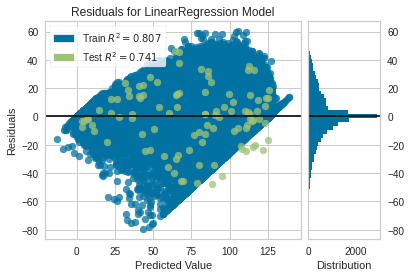

In [ ]:
# Plot residuals for polynomial regression
visualizer = yr.ResidualsPlot(polynomial_regressor)
visualizer.fit(X_train_poly, y_regression)
visualizer.score(X_test_poly, y_test_scaled)
visualizer.show()

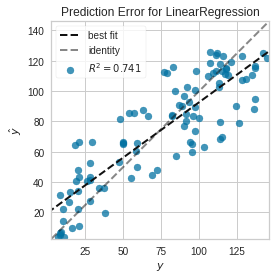

In [ ]:
visualizer = yr.PredictionError(LinearRegression())
visualizer.fit(X_train_poly, y_regression)
visualizer.score(X_test_poly, y_test_scaled)
visualizer.show()

## Random Forest Regression

In [ ]:
# Perform grid search for Random Forest regression
estimators_space = [60, 70, 80, 90, 100]
features_space = [1, 2, 3]
depth_space = [4, 5, 6, 7, 8, 9]

parameters_grid = {
    "n_estimators": estimators_space,
    "max_features": features_space,
    "max_depth": depth_space,
}
random_forest_regressor = tune_hyperparameters(
    RandomForestRegressor(), parameters_grid, X_regression, y_regression
)


The best parameters are {'max_depth': 6, 'max_features': 2, 'n_estimators': 100} with a score of 0.7953705092671342


In [ ]:
# Make predictions on training and test data
training_predictions = random_forest_regressor.predict(X_regression)
test_predictions = random_forest_regressor.predict(X_test_scaled)

In [ ]:
# Calculate metrics
random_forest_regression_metrics = calculate_regression_metrics(
    "Random Forest Regression", y_regression, training_predictions, y_test_scaled, test_predictions
)
random_forest_regression_metrics


,Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.815437,0.740423
RMSE,17.908629,21.172063


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


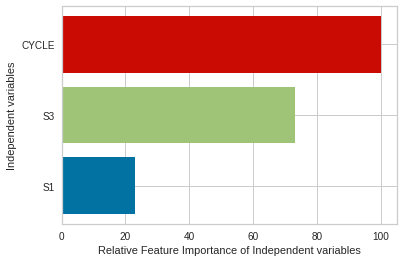

In [ ]:
# Plot model coefficients for linear regression

viz= FeatureImportances(random_forest_regressor)
viz.fit(X_regression, y_regression)
viz.ax.set_xlabel("Relative Feature Importance of Independent variables")
viz.ax.set_ylabel("Independent variables")

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


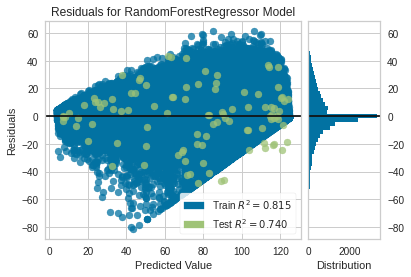

In [ ]:
# Plot residuals for random forest regression
visualizer = yr.ResidualsPlot(random_forest_regressor)
visualizer.fit(X_regression, y_regression)
visualizer.score(X_test_scaled, y_test_scaled)
visualizer.show()


## Comparison of Regression Algorithms

In [ ]:
# Combine regression metrics over multiple models
regression_metrics = pd.concat(
    [
        linear_regression_metrics,
        polynomial_regression_metrics,
        random_forest_regression_metrics,
    ],
    axis=1,
)
test_metrics = regression_metrics.filter(like="(Test)", axis=1)
regression_metrics

,Linear Regression (Training),Linear Regression (Test),Polynomial Regression (Training),Polynomial Regression (Test),Random Forest Regression (Training),Random Forest Regression (Test)
R2,0.744633,0.669816,0.807287,0.741345,0.815437,0.740423
RMSE,21.065541,23.878555,18.299779,21.134431,17.908629,21.172063


In [ ]:
regression_metrics_t = regression_metrics.transpose()
regression_metrics_t['label'] = regression_metrics_t.apply(lambda x: 'Test' if 'Test' in x.name else 'Training', axis=1)
regression_metrics_t['model'] = ['Linear Regression', 'Linear Regression', 'Polynomial Regression','Polynomial Regression', 'Random Forest Regression', 'Random Forest Regression']


Text(0, 0.5, 'R2 score')

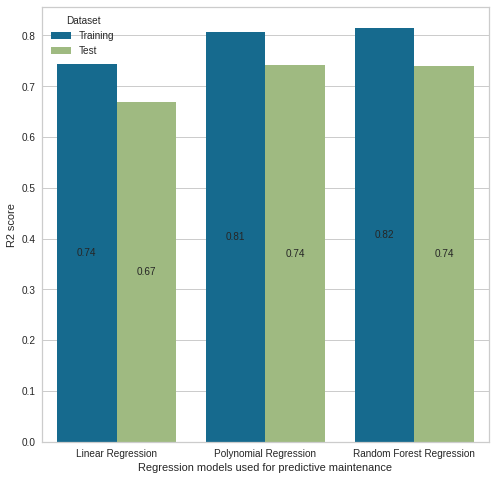

In [ ]:
# Compare R2 across models
plt.figure(figsize=(8, 8))

ax = sns.barplot(x=regression_metrics_t.model, y=regression_metrics_t.R2, hue=regression_metrics_t.label)
plt.legend(title='Dataset')

for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(s=text, xy=xy, ha='center', va='center')

ax.set_xlabel('Regression models used for predictive maintenance')
ax.set_ylabel('R2 score')

Text(0, 0.5, 'Root mean squared error')

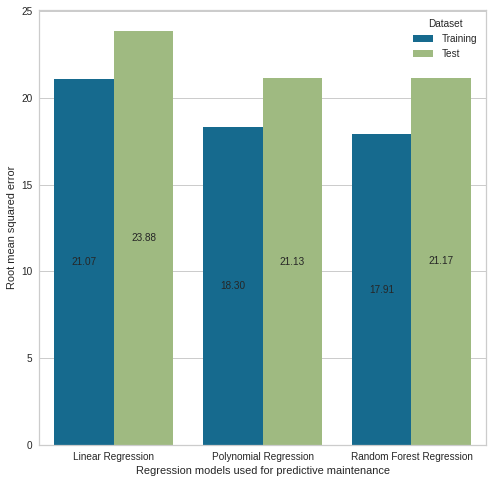

In [ ]:
# Compare RMSE across models
plt.figure(figsize=(8, 8))

ax = sns.barplot(x=regression_metrics_t.model, y=regression_metrics_t.RMSE, hue=regression_metrics_t.label)
plt.legend(title='Dataset')

for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(s=text, xy=xy, ha='center', va='center')

ax.set_xlabel('Regression models used for predictive maintenance')
ax.set_ylabel('Root mean squared error')

# Classification

In [ ]:
# Define subsets of data
features = [cycle] + sensors
target = 'TTF_LABEL'

X_train = train_scaled[features]
y_train = train_scaled[target]

X_test = test_scaled[features]
y_test = test_scaled[target]

## Helper Methods

### Tune Hyperparameters

In [ ]:
def tune_hyperparameters_c(
    classifier, parameters_grid, X_train, y_train, cv=5, score=None
):
    """Tune the hyperparameters of a regression model using Grid Search

    Args:
        regressor (str): The model name identifier
        parameters_grid (dict): The hyperparameters grid
        X_train (dataframe): The training features
    """
    grid = GridSearchCV(classifier, parameters_grid, cv=cv, scoring=score)
    grid.fit(X_train, y_train)
    print(
        f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}"
    )
    return grid.best_estimator_

### Generate prediction probabilities

In [ ]:
def generate_scores(classifer, X_train):
    """Generate the scores of the model

    Args:
        classifer (str): The model name identifier
        X_train (dataframe): The training features
    """
    return classifer.predict_proba(X_train)[:, 1], classifer.predict_proba(X_test)[:, 1]

### Classification Metrics
Metrics to be considered:
- Accuracy
- Precision
- Recall
- F1
- ROC AUC

In [ ]:
def calculate_classification_metrics(model_name, training_actual, training_predictions, training_scores, test_actual, test_predictions, test_scores):
    """Calculate the classification metrics

    Args:
        model_name (str): The model name identifier
        training_actual (dataframe): The training actual values
        training_predictions (dataframe): The training predicted values
        test_actual (dataframe): The test actual values
        test_predictions (dataframe): The test predicted values
    """
    training_metrics = {
        "Accuracy": accuracy_score(training_actual, training_predictions),
        "Precision": precision_score(training_actual, training_predictions),
        "Recall": recall_score(training_actual, training_predictions),
        "F1": f1_score(training_actual, training_predictions),
        "ROC AUC": roc_auc_score(training_actual, training_scores),
    }

    test_metrics = {
        "Accuracy": accuracy_score(test_actual, test_predictions),
        "Precision": precision_score(test_actual, test_predictions),
        "Recall": recall_score(test_actual, test_predictions),
        "F1": f1_score(test_actual, test_predictions),
        "ROC AUC": roc_auc_score(test_actual, test_scores),
    }

    metrics = {
        f"{model_name} (Training)": training_metrics,
        f"{model_name} (Test)": test_metrics
    }

    return pd.DataFrame.from_dict(metrics)

### Plot Confusion matrix

In [ ]:
def plot_confusion_matrix(
    actual, predicted, cmap="Blues"):
    """Plot the confusion matrix

    Args:
        actual (array): The actual values
        predicted (array): The predicted values
        cmap (str): The color map
    """
    cm = confusion_matrix(actual, predicted)
    group_labels = ["True Positive", "False Positive", "False Negative", "True Negative"]
    counts = [
        "{0:0.0f}".format(value) for value in cm.flatten()
    ]
    percentages = [
        "{0:.2%}".format(value)
        for value in cm.flatten() / np.sum(cm)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_labels, counts, percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt="", cmap=cmap)

## Gaussian Naive Bayes 

In [ ]:
# Define the naive bayes model and fit it to the training data
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Make predictions on training and test data
training_predictions = naive_bayes_model.predict(X_train)
test_predictions = naive_bayes_model.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(naive_bayes_model, X_train)

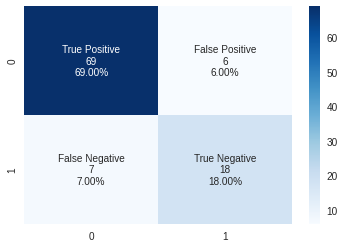

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [ ]:
# Calculate the classification metrics
naive_bayes_classification_metrics = calculate_classification_metrics('Naive Bayes', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
naive_bayes_classification_metrics

,Naive Bayes (Training),Naive Bayes (Test)
Accuracy,0.926373,0.870000
Precision,0.691729,0.750000
Recall,0.920000,0.720000
F1,0.789700,0.734694
ROC AUC,0.980129,0.958933


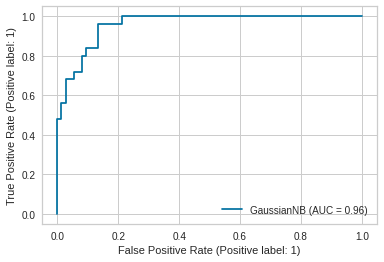

In [ ]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(naive_bayes_model, X_test, y_test)

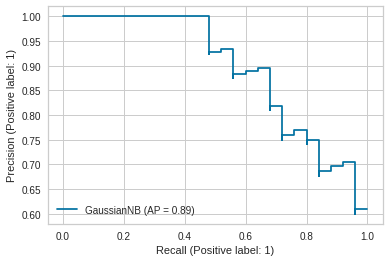

In [ ]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(naive_bayes_model, X_test, y_test)

## Logistic Regression

In [ ]:
# Perform grid search on logistic regression
c_space = [.01, 0.1, 1.0, 10]
parameters_grid = { "C": c_space }
tuned_logistic_classifier = tune_hyperparameters_c(LogisticRegression(), parameters_grid, X_train, y_train, score='roc_auc')

The best parameters are {'C': 1.0} with a score of 0.9798043468427091


In [ ]:
# Fit the classifier and predict on test data
training_predictions = tuned_logistic_classifier.predict(X_train)
test_predictions = tuned_logistic_classifier.predict(X_test)

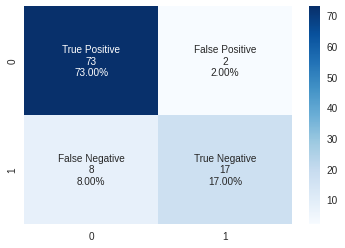

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [ ]:
# Calculate the classification metrics
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_logistic_classifier, X_train)
logistic_regression_classification_metrics = calculate_classification_metrics('Logistic Regression', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
logistic_regression_classification_metrics

,Logistic Regression (Training),Logistic Regression (Test)
Accuracy,0.945858,0.900000
Precision,0.847529,0.894737
Recall,0.780000,0.680000
F1,0.812364,0.772727
ROC AUC,0.980041,0.959467


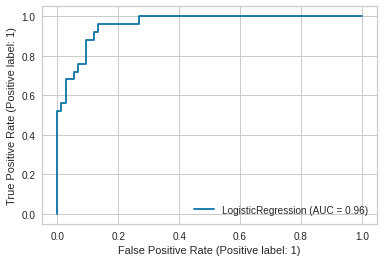

In [ ]:
RocCurveDisplay.from_estimator(tuned_logistic_classifier, X_test, y_test)

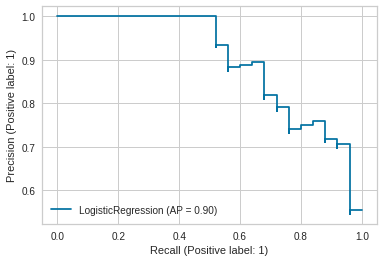

In [ ]:
PrecisionRecallDisplay.from_estimator(tuned_logistic_classifier, X_test, y_test)

## Random Forest Classifier

In [ ]:
# Perform grid search on random forest
max_depth_space = [2, 3, 4, 5, 6, 7, 8]
criterion_space = ["gini", "entropy"]
parameters_grid = { "max_depth": max_depth_space, "criterion": criterion_space }

tuned_random_forest_classifier = tune_hyperparameters_c(RandomForestClassifier(random_state=42), parameters_grid, X_train, y_train, score='roc_auc')


The best parameters are {'criterion': 'entropy', 'max_depth': 6} with a score of 0.98173441574295


In [ ]:
# Make predictions on training and test data
training_predictions = tuned_random_forest_classifier.predict(X_train)
test_predictions = tuned_random_forest_classifier.predict(X_test)
prediction_probabilities_training, prediction_probabilities_test = generate_scores(tuned_random_forest_classifier, X_train)

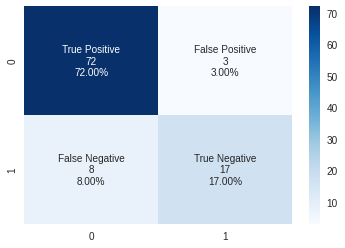

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, test_predictions)

In [ ]:
# Calculate the classification metrics
random_forest_classification_metrics = calculate_classification_metrics('Random Forest', y_train, training_predictions, prediction_probabilities_training, y_test, test_predictions, prediction_probabilities_test)
random_forest_classification_metrics

,Random Forest (Training),Random Forest (Test)
Accuracy,0.951190,0.890000
Precision,0.872553,0.850000
Recall,0.790645,0.680000
F1,0.829582,0.755556
ROC AUC,0.985366,0.963200


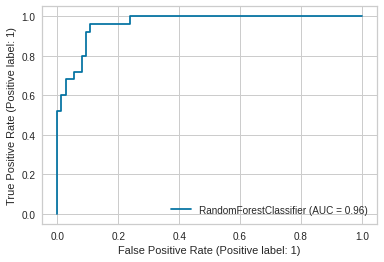

In [ ]:
# Plot the ROC curve
RocCurveDisplay.from_estimator(tuned_random_forest_classifier, X_test, y_test)

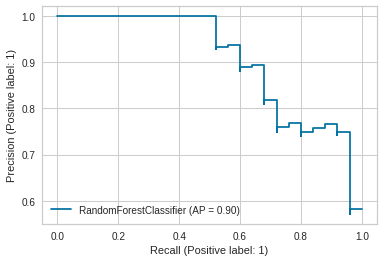

In [ ]:
# Plot precision-recall curve
PrecisionRecallDisplay.from_estimator(tuned_random_forest_classifier, X_test, y_test)

## Comparison of classification algorithms

In [ ]:
classification_metrics = pd.concat([naive_bayes_classification_metrics, logistic_regression_classification_metrics, random_forest_classification_metrics], axis=1)
test_classification_metrics = classification_metrics.filter(like="(Test)", axis=1)
test_classification_metrics

,Naive Bayes (Test),Logistic Regression (Test),Random Forest (Test)
Accuracy,0.870000,0.900000,0.890000
Precision,0.750000,0.894737,0.850000
Recall,0.720000,0.680000,0.680000
F1,0.734694,0.772727,0.755556
ROC AUC,0.958933,0.959467,0.963200
